In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

from SmithZero import D2torchEngine

In [3]:
torch.manual_seed(42)

## Data Preparation 
* [ImageNet2012](https://github.com/DoranLyong/ImageNet2012-download)
* [Pytorch Dataloader](https://pytorch.org/vision/stable/datasets.html#imagenet)

In [4]:
import torchvision.datasets as datasets 
import torchvision.transforms as T


# === data transformation === # 
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])


train_T = T.Compose([   T.RandomResizedCrop(224),
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        normalize,
                    ])

test_T = T.Compose([T.Resize(256),
                    T.CenterCrop(224),
                    T.ToTensor(),
                    normalize,
                    ])                  


# === dataset object === # 
train_dataset = datasets.ImageFolder(   root= './dataset/train',
                                        transform= train_T, 
                                    )

test_dataset = datasets.ImageFolder(    root= "./dataset/val", 
                                        transform= test_T,
                                    ) 

## Data Batching 

In [5]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_dataset,
                        batch_size=256,
                        shuffle=True, 
                        num_workers=4 
                        )

testloader = DataLoader(test_dataset,
                        batch_size=256,
                        num_workers=4
                        )

```ImageNet2012``` has 1000-class 

***
# Transfer Learning in Practice (AlexNet)

In [6]:
from torchvision.models import alexnet 

### Pre-trained Model

In [7]:
# creating an instance of AlexNet without loading its pre-trained weights 
model = alexnet(pretrained=False) 

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Looking the structure, the architecture has three main elements:
* ```features```, ```avgpool```, ```classifier``` 
    * the featurizer contains five typical convolutional blocks 
    * ```avgpool```: whatever the image size it gets as input, it will ```return a tensor with the desired size```
    * the classifier has two hidden layers using 50% dropout 

In [8]:
list(model.named_modules())

[('',
  AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_

### Loading Weights 
You can get the URL from the ```model_urls``` variable in ```torchvision.models.alexnet```.

In [9]:
from torchvision.models.alexnet import model_urls
from torch.hub import load_state_dict_from_url    # (ref) https://pytorch.org/docs/stable/hub.html

# get pre-trained weights URL 
url = model_urls['alexnet']
print(url)

https://download.pytorch.org/models/alexnet-owt-7be5be79.pth


In [10]:
# loading the pre-trained weights from the URL  to your local disk 
# (ref) https://www.programcreek.com/python/example/118276/torchvision.models.utils.load_state_dict_from_url
state_dict = load_state_dict_from_url(  url, 
                                        model_dir = 'pretrained',
                                        progress=True,
                                    )

In [11]:
state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [12]:
# Loading model 
model.load_state_dict(state_dict)

<All keys matched successfully>

## Model Freezing 
If you don't want to continue training the whole model : 
* you could pick it up where it was left off(중단) by the original authors
* and ```resume training``` using your own dataset.

```Freezing the model``` means that <b>it won't learn anymore</b>, that is, <b>its parameters/weights will not be updated anymore</b>.
* what best characterizes a tensor representing a ```learnable parameter```? 
    * it requires ```gradients```
    * So, we can make them stop learning anything by changing its boolean like a switch (ON/OFF)

In [13]:
# Show the learnable parameters of the model 
for parameter in model.parameters():
    print(f"{parameter.size()}, {parameter.requires_grad}")

torch.Size([64, 3, 11, 11]), True
torch.Size([64]), True
torch.Size([192, 64, 5, 5]), True
torch.Size([192]), True
torch.Size([384, 192, 3, 3]), True
torch.Size([384]), True
torch.Size([256, 384, 3, 3]), True
torch.Size([256]), True
torch.Size([256, 256, 3, 3]), True
torch.Size([256]), True
torch.Size([4096, 9216]), True
torch.Size([4096]), True
torch.Size([4096, 4096]), True
torch.Size([4096]), True
torch.Size([1000, 4096]), True
torch.Size([1000]), True


In [14]:
# set gradient as OFF 

def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

In [15]:
# free your model 
freeze_model(model)

In [16]:
for parameter in model.parameters():
    print(f"{parameter.size()}, {parameter.requires_grad}")

torch.Size([64, 3, 11, 11]), False
torch.Size([64]), False
torch.Size([192, 64, 5, 5]), False
torch.Size([192]), False
torch.Size([384, 192, 3, 3]), False
torch.Size([384]), False
torch.Size([256, 384, 3, 3]), False
torch.Size([256]), False
torch.Size([256, 256, 3, 3]), False
torch.Size([256]), False
torch.Size([4096, 9216]), False
torch.Size([4096]), False
torch.Size([4096, 4096]), False
torch.Size([4096]), False
torch.Size([1000, 4096]), False
torch.Size([1000]), False


your model is frozen now :) 

## Replacing the top of the model (for fine-tune)
* ```backbone``` : bottom 
* ```classifier``` : top 

In [17]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


![](./page_imgs/alexnet.png)

*Source: Generated using Alexander Lenail’s [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author* 

In [18]:
# Check the top 
model.classifier[6]   

Linear(in_features=4096, out_features=1000, bias=True)

```out_features=1000``` ⇒ nodes for 1000-class

In [19]:
torch.manual_seed(11)

#model.classifier[6] = nn.Linear(4096, 10)    # for cifar-10
model.classifier[6] = nn.Linear(4096, 1000)  # for ImageNet

Notice that the <b>number of input features remains the same</b> since it still takes the
output from the hidden layer that precedes it.

(!) The <b>new output layer requires gradients by default</b>, but we can double-check it:

In [20]:
for name, param in model.named_parameters(): 
    print(f"{name}, {param.requires_grad}")

features.0.weight, False
features.0.bias, False
features.3.weight, False
features.3.bias, False
features.6.weight, False
features.6.bias, False
features.8.weight, False
features.8.bias, False
features.10.weight, False
features.10.bias, False
classifier.1.weight, False
classifier.1.bias, False
classifier.4.weight, False
classifier.4.bias, False
classifier.6.weight, True
classifier.6.bias, True


You can see that the top part by ```model.classifier[6]``` is set to ```True```.
* These are the only things to be trained

*** 
## W&B setup 

In [21]:
# === hyperparameter dict === # 
# you can receive with .yaml or .json 

hyperparams = dict(
        seed=42, 
        epochs=50,
        classes=1000,
        batch_size=128,
        n_workers=4,
        learning_rate=3e-4,
        dropout_p = 0.5,
        dataset="ImageNet",
        architecture="AlexNet")

In [22]:
import wandb 

wandb.login() 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: doranlyong (use `wandb login --relogin` to force relogin)


True

In [23]:
proj_name = "AlexNet-ImageNet"

wandb.init(project=proj_name, config=hyperparams)
config = wandb.config 

/home/milky/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Model Configuration 

In [24]:
torch.manual_seed(17)

loss_fn = nn.CrossEntropyLoss(reduction='mean') 
optimizer = optim.Adam( model.parameters(), # (!) be sure to pass in the model.parameters() 
                        lr=config.learning_rate, 
                    ) 

In [25]:
AgentDL = D2torchEngine(model, loss_fn, optimizer)

AgentDL.set_loaders(trainloader, testloader)
AgentDL.set_wandb(wandb)

 92%|█████████▏| 92/100 [00:37<00:03,  2.44it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.23E-03


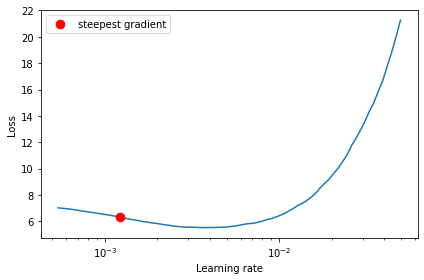

In [26]:
# === Learning Rate Range Test === # 
fig = AgentDL.lr_range_test(end_lr=1e-1, num_iter=100)

In [26]:
# === reset the optimzier === # 
#reset_optimizer = optim.Adam(  model.parameters(), lr=5.34e-3) 
#AgentDL.set_optimizer(reset_optimizer) 

## Set a scheduler 

In [27]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=4, eta_min=1e-5, last_epoch= -1, verbose=False)

AgentDL.set_lr_scheduler(scheduler)

In [28]:
AgentDL.optimizer == AgentDL.scheduler.optimizer

True

## Model Training 

In [29]:
AgentDL.train(n_epochs=100, seed=config.seed)

100%|██████████| 100/100 [57:52:40<00:00, 2083.60s/it]


In [31]:
# evaluating our model after training 
results = D2torchEngine.loader_apply(AgentDL.val_loader, AgentDL.correct, reduce="sum")
print(results)

tensor([[ 0, 50],
        [ 0, 50],
        [ 0, 50],
        ...,
        [ 0, 50],
        [ 0, 50],
        [ 0, 50]])


***
# More Effective Transfer Learning (p.582)
To split the ```feature extraction``` and ```actual training``` phases